<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21222740/Final_Training_for_GRU_without_GLOVE_54_testing_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and Imports

In [1]:
#Download and Imports
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional

In [ ]:
 #IMPORT YOUR KAGGLE DATA SOURCES

In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


# Load dataset

In [3]:
# Load dataset
data = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')


## Random Sampling of Dataset

In [4]:
# Sample 20% of the original dataset randomly while ensuring reproducibility with a fixed random seed.
data = data.sample(frac =0.2, random_state=42)
print(data.shape)

(600000, 3)


# Preprocessing the data

## Initialize Lemmatizer

In [5]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()


## Tokenization and Lemmatization function

In [6]:
# Tokenization and Lemmatization function
def message_to_token_list(s, words, tokenizer):
    tokens = tokenizer.tokenize(s)
    lowercased_tokens = [t.lower() for t in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in lowercased_tokens]
    useful_tokens = [t for t in lemmatized_tokens if t in words]
    return useful_tokens

## Tokenize the reviews

In [7]:
# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review_text'])
sequences = tokenizer.texts_to_sequences(data['review_text'])

## Padding sequences

In [8]:
# Padding sequences
padded_sequences = pad_sequences(sequences, padding='post')

## Get labels

In [9]:
# Get labels
labels = data['class_index'] - 1  # Adjust class index to be 0-based for classification

## Splitting dataset

In [10]:
from sklearn.model_selection import train_test_split
#splitting dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)



## Print the shapes

In [11]:
print(X_train_val.shape)
print(X_test.shape)
print(y_train_val.shape)
print(y_test.shape)

(480000, 224)
(120000, 224)
(480000,)
(120000,)



## Split X_train and y_train into two separate training datasets

In [12]:
# Split X_train and y_train into two separate training datasets
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42, stratify=y_train_val)

## Split Dataset again to train easy

In [13]:
X_train_first, X_train_second, y_train_first, y_train_second = train_test_split(X_train_1, y_train_1, test_size=0.5, random_state=42, stratify=y_train_1)
X_train_third, X_train_fourth, y_train_third, y_train_fourth = train_test_split(X_train_2, y_train_2, test_size=0.5, random_state=42, stratify=y_train_2)
# Output the shapes to verify the split
print("X_train_1 shape:", X_train_1.shape)
print("y_train_1 shape:", y_train_1.shape)
print("X_train_2 shape:", X_train_2.shape)
print("y_train_2 shape:", y_train_2.shape)


X_train_1 shape: (240000, 224)
y_train_1 shape: (240000,)
X_train_2 shape: (240000, 224)
y_train_2 shape: (240000,)


## Split Dataset for validation and testing

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test)

# Buiding and Training Model

## Model Definition

#### This model is designed for multi-class text classification using a Bidirectional GRU architecture:

##### Input Shape: Handles sequences based on X_train_first.shape.

##### Embedding Layer: Transforms input words into dense vectors of size 200 using a trainable embedding matrix.

##### GRU Layer: Utilizes a Bidirectional GRU with 64 units, capturing context in both directions.
##### Dropout Layers: Applied after the GRU and before the output to prevent overfitting (50% dropout rate).
##### Global Max Pooling: Reduces dimensionality by summarizing significant features.
##### Output Layer: A Dense layer with softmax activation for classifying into 5 ratings (1 to 5).
##### Compilation: Uses sparse categorical crossentropy loss and Adam optimizer, tracking accuracy.

In [15]:

# Define the  model
sequence_length = X_train_first.shape
embedding_dim = 200  #embedding dimension
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Build the model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length= sequence_length,
                    weights=[embedding_matrix],
                    trainable=True))

# GRU layer with return_sequences=True for compatibility with pooling
model.add(Bidirectional(GRU(64, return_sequences=True)))

# Dropout after GRU layer
model.add(Dropout(0.5))  # after GRU

# Global Max Pooling layer for dimensionality reduction
model.add(GlobalMaxPool1D())

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Output layer for classification into 5 classes (rating from 1 to 5)
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      71,846,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,846,000 (274.07 MB)

 Trainable params: 71,846,000 (274.07 MB)

 Non-trainable params: 0 (0.00 B)


## Train the model

### 3 epochs and 256 batch size

In [16]:

# Train the model
history = model.fit( X_train_first, y_train_first, validation_data=(X_val,y_val), epochs=10, batch_size=256, verbose=1)



Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - accuracy: 0.3660 - loss: 1.4105 - val_accuracy: 0.5050 - val_loss: 1.2074
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.5508 - loss: 1.0542 - val_accuracy: 0.5034 - val_loss: 1.1519
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.6396 - loss: 0.8736 - val_accuracy: 0.4975 - val_loss: 1.1592
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.7181 - loss: 0.7081 - val_accuracy: 0.4876 - val_loss: 1.2082
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.7826 - loss: 0.5613 - val_accuracy: 0.4757 - val_loss: 1.3151
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8301 - loss: 0.4441 - val_accuracy: 0.4628 - val_loss: 1.4434
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.8647 - loss: 0.3527 - val_accuracy: 0.4565 - val_loss: 1.6118
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8905 - loss: 0.2890 - 

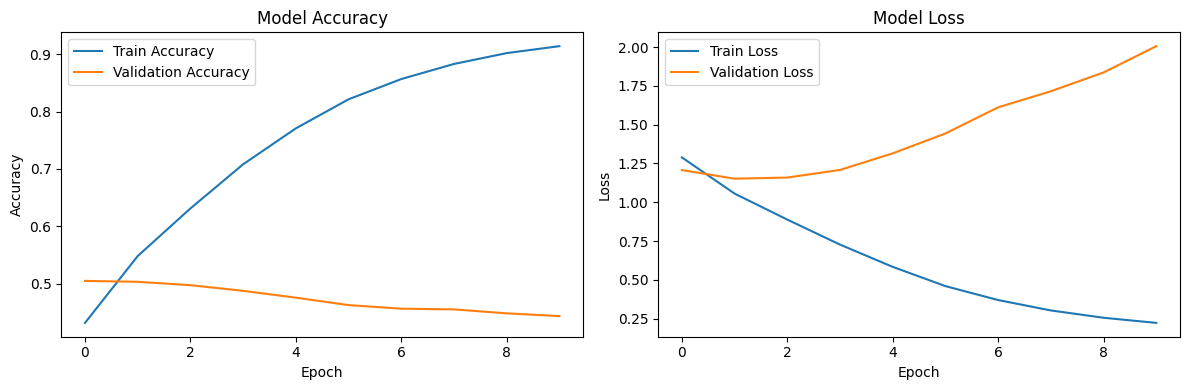

In [18]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values for all epochs
plt.figure(figsize=(12, 4))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values for all epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


### Inroducing new data set(2 epochs)

In [20]:
# Continue Train the model by introducing new data set
history = model.fit( X_train_second, y_train_second, validation_data=(X_val,y_val), epochs=2, batch_size=256, verbose=1, initial_epoch = 1)



Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.5711 - loss: 1.0031 - val_accuracy: 0.5104 - val_loss: 1.1247


### Extra 2 epochs

In [21]:
# Continue Train the model by introducing new data set
history = model.fit( X_train_fourth, y_train_fourth, validation_data=(X_val,y_val), epochs=2, batch_size=256, verbose=1)



Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.5120 - loss: 1.1343 - val_accuracy: 0.5200 - val_loss: 1.1112
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.6140 - loss: 0.9168 - val_accuracy: 0.5163 - val_loss: 1.1090


In [23]:
# Contnue Train the model
history = model.fit( X_train_third, y_train_third, validation_data=(X_val,y_val), epochs=1, batch_size=256, verbose=1)


469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.5210 - loss: 1.1103 - val_accuracy: 0.5403 - val_loss: 1.0843


## Testing Model

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}") #0.001 , bidirectional GRU and 3 epochs

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.5423 - loss: 1.0826
Test Accuracy: 0.5406354069709778


In [25]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Predict on validation set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)  # Convert to class labels

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Compute F1-score, precision, and recall
f1 = f1_score(y_val, y_pred_classes, average='weighted')
precision = precision_score(y_val, y_pred_classes, average='weighted')
recall = recall_score(y_val, y_pred_classes, average='weighted')

print(f'F1-Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Classification report for detailed metrics
print(classification_report(y_val, y_pred_classes))


750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
Accuracy: 0.5403
F1-Score: 0.5239
Precision: 0.5308
Recall: 0.5403
              precision    recall  f1-score   support

           0       0.58      0.76      0.65      4841
           1       0.49      0.37      0.42      4738
           2       0.49      0.43      0.46      4769
           3       0.52      0.34      0.41      4808
           4       0.57      0.79      0.67      4844

    accuracy                           0.54     24000
   macro avg       0.53      0.54      0.52     24000
weighted avg       0.53      0.54      0.52     24000

